In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import easyocr

# Inicializar EasyOCR una sola vez (en inglés)
reader = easyocr.Reader(['en'], gpu=False)  # gpu=True si tienes GPU NVIDIA

matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

images_path = './Images/'
images_path_english = './Images/English/'
images_path_japanese = './Images/Japanese/'


Using CPU. Note: This module is much faster with a GPU.


In [ ]:
import cv2
import numpy as np
import itertools

def contorno_toca_borde(contorno, w, h, margen=10):
    pts = contorno.reshape(-1, 2)
    if (
        np.any(pts[:, 0] <= margen) or
        np.any(pts[:, 1] <= margen) or
        np.any(pts[:, 0] >= w - margen) or
        np.any(pts[:, 1] >= h - margen)
    ):
        return True
    return False


# ------------------------------------------------------------
# 1. Cargar y preprocesar
# ------------------------------------------------------------
def cargar_y_preprocesar(ruta_img, ancho_max=1280):
    img = cv2.imread(ruta_img)
    if img is None:
        raise ValueError("No se pudo leer la imagen. Revisa la ruta.")

	# Ponemos un ancho común y hacemos que el alto se ajuste
    height, width = img.shape[:2]
    if width > ancho_max:
        escalawidth = ancho_max / width
        nuevoheight = int(height * escalawidth)
        img = cv2.resize(img, (ancho_max, nuevoheight))

    # Convertir a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Aplicar desenfoque bilateral para reducir ruido manteniendo bordes
    img_blur = cv2.bilateralFilter(img_gray, 11, 17, 17)
    
    # Usar umbralización adaptativa para mejorar contraste
    img_thresh = cv2.adaptiveThreshold(
        img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Uso Canny con umbrales más bajos para detectar más bordes
    edges = cv2.Canny(img_blur, 30, 100)

    # Dilato los bordes para unirlos
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    return img, img_gray, edges

# ------------------------------------------------------------
# 2B. Contornos (fallback)
# ------------------------------------------------------------
def encontrar_carta_como_quad(edges, margen_borde=15):
    h, w = edges.shape[:2]
    area_imagen = h * w

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidatos = []
    for c in cnts:
        area = cv2.contourArea(c)
        
		# Área mínima relativa (5% del área de la imagen)
        area_minima = area_imagen * 0.15
        # Área máxima (90% del área de la imagen)
        area_maxima = area_imagen * 0.90
        
        if area < area_minima or area > area_maxima:
            continue

		# Si el contorno toca los bordes de la imagen, lo descartamos
        pts = c.reshape(-1, 2)
        if (
            np.any(pts[:, 0] <= margen_borde)
            or np.any(pts[:, 1] <= margen_borde)
            or np.any(pts[:, 0] >= w - margen_borde)
            or np.any(pts[:, 1] >= h - margen_borde)
        ):
            continue

        # Aproximar el contorno a un polígono
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # Preferir cuadriláteros, pero aceptar otros si tienen área suficiente
        if len(approx) >= 4:
            # Calculamos el rectángulo mínimo que encierra el contorno
            rect = cv2.minAreaRect(c)
            
            # Descartamos líneas
            (wr, hr) = rect[1]
            if wr == 0 or hr == 0:
                continue
            
            # Calcular el aspect ratio (debería estar cerca de 0.715 para cartas MTG)
            aspect_ratio = min(wr, hr) / max(wr, hr)
            
            # Aceptar ratios entre 0.5 y 0.9 (más flexible)
            if aspect_ratio < 0.5:
                continue
            
            # Calcular qué tan "lleno" está el contorno (área vs rectángulo)
            rect_area = wr * hr
            extent = area / rect_area if rect_area > 0 else 0
            
            # Una carta debería tener extent > 0.7 (es bastante rectangular)
            if extent < 0.65:
                continue
            
            candidatos.append((area, rect, approx))

    if not candidatos:
        return None

	# Busco el rectángulo con mayor área
    candidatos.sort(key=lambda x: x[0], reverse=True)
    
	# Retorno las coordenadas del rectángulo (usando approx si tiene 4 puntos, sino box)
    area, rect, approx = candidatos[0]
    
    if len(approx) == 4:
        return approx.reshape(4, 2)
    else:
        box = cv2.boxPoints(rect)
        return box

# ------------------------------------------------------------
# Ordenar y rectificar
# ------------------------------------------------------------
def ordenar_puntos(pts):
    """Ordenar puntos: [top-left, top-right, bottom-right, bottom-left]"""
    pts = np.array(pts, dtype=np.float32)
    
    # Ordenar por X
    sorted_x = pts[np.argsort(pts[:, 0])]
    
    # Dividir: izquierda (2 primeros) y derecha (2 últimos)
    izq = sorted_x[:2]
    der = sorted_x[2:]
    
    # Ordenar cada lado por Y (arriba → abajo)
    izq = izq[np.argsort(izq[:, 1])]
    der = der[np.argsort(der[:, 1])]
    
    # Devolver en orden: tl, tr, br, bl
    return np.array([izq[0], der[0], der[1], izq[1]], dtype=np.float32)


def rectificar_carta(img_color, pts_src, ancho_dest=720):
    """Versión simplificada con ordenamiento correcto"""
    alto_dest = int(ancho_dest / 0.715)
    
    # Ordenamos los puntos antes de la homografía
    pts_src = ordenar_puntos(pts_src)
    
    # Puntos destino en el MISMO orden
    pts_dst = np.float32([
        [0, 0],                  # top-left
        [ancho_dest, 0],         # top-right
        [ancho_dest, alto_dest], # bottom-right
        [0, alto_dest]           # bottom-left
    ])
    
    # Calcular homografía y rectificar
    M = cv2.getPerspectiveTransform(pts_src, pts_dst)
    warped = cv2.warpPerspective(img_color, M, (ancho_dest, alto_dest))
    
    return warped





# ===================== MÉTODO 4: fallback ratio =====================
def metodo_fallback_ratio(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    h, w = edges.shape[:2]
    cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    mejor = None
    mejor_diff = 999
    for c in cnts:
        if contorno_toca_borde(c, w, h, margen=10):
            continue
        rect = cv2.minAreaRect(c)
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue
        ar = min(wr, hr) / max(wr, hr)
        diff = abs(ar - 0.715)
        if diff < mejor_diff:
            mejor_diff = diff
            mejor = rect

    if mejor is None:
        return None

    box = cv2.boxPoints(mejor)
    return box.reshape(4, 2)


def metodo_adaptativo_rect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # binarización local para luces no uniformes
    th = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15, 5
    )

    kernel = np.ones((3, 3), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

    h, w = th.shape[:2]
    area_img = h * w
    cnts, _ = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    candidatos = []
    for c in cnts:
        if contorno_toca_borde(c, w, h, margen=10):
            continue

        area = cv2.contourArea(c)
        if area < area_img * 0.10 or area > area_img * 0.95:
            continue

        rect = cv2.minAreaRect(c)
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue

        ar = min(wr, hr) / max(wr, hr)
        if not (0.63 <= ar <= 0.78):
            continue

        candidatos.append((area, rect, c))

    if not candidatos:
        return None

    candidatos.sort(key=lambda x: x[0], reverse=True)
    _, rect, c = candidatos[0]
    box = cv2.boxPoints(rect)
    return box.reshape(4, 2)


def metodo_hough_rectas(img_color, canny1=50, canny2=150, min_line_len=80, max_line_gap=10):
    """
    Intenta detectar la carta buscando 4 lados casi rectos con Hough.
    Devuelve 4 puntos en el orden: tl, tr, br, bl o None.
    """
    h, w = img_color.shape[:2]

    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, canny1, canny2)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        return None

    verticales = []
    horizontales = []

    for l in lines:
        x1, y1, x2, y2 = l[0]
        if x2 == x1 and abs(y2 - y1) > 20:
            verticales.append((x1, y1, x2, y2))
        else:
            m = (y2 - y1) / (x2 - x1 + 1e-6)
            if abs(m) < 0.2:  # casi horizontal
                horizontales.append((x1, y1, x2, y2))
            elif abs(m) > 5:  # casi vertical pero no x2==x1
                verticales.append((x1, y1, x2, y2))

    if len(verticales) < 1 or len(horizontales) < 1:
        return None

    # extremos
    xs = [min(v[0], v[2]) for v in verticales] + [max(v[0], v[2]) for v in verticales]
    ys = [min(hh[1], hh[3]) for hh in horizontales] + [max(hh[1], hh[3]) for hh in horizontales]

    x_min = max(0, min(xs))
    x_max = min(w - 1, max(xs))
    y_min = max(0, min(ys))
    y_max = min(h - 1, max(ys))

    # filtramos rectángulos raros
    ancho = x_max - x_min
    alto = y_max - y_min
    if ancho < w * 0.1 or alto < h * 0.1:
        return None

    ar = min(ancho, alto) / max(ancho, alto)
    if not (0.55 <= ar <= 0.85):
        # ratio demasiado raro para una carta típica
        return None

    quad = np.array([
        [x_min, y_min],  # tl
        [x_max, y_min],  # tr
        [x_max, y_max],  # br
        [x_min, y_max],  # bl
    ], dtype=np.float32)

    return quad





Método adaptativo encontró carta:  1
Contorno encontrado:  2
Contorno encontrado:  3
Contorno encontrado:  4
Contorno encontrado:  3
Contorno encontrado:  4
Método hough encontró carta:  5
Contorno encontrado:  6
Método hough encontró carta:  5
Contorno encontrado:  6
Contorno encontrado:  7
Contorno encontrado:  8
Contorno encontrado:  7
Contorno encontrado:  8
Método adaptativo encontró carta:  9
Método adaptativo encontró carta:  9
Método hough encontró carta:  10
Método hough encontró carta:  10
Método hough encontró carta:  11
Método hough encontró carta:  11
Método hough encontró carta:  12
Método hough encontró carta:  12
Método hough encontró carta:  13
Método hough encontró carta:  13
Método adaptativo encontró carta:  14
Contorno encontrado:  15
Método adaptativo encontró carta:  14
Contorno encontrado:  15
Método adaptativo encontró carta:  16
Método adaptativo encontró carta:  16
Método adaptativo encontró carta:  17
Método adaptativo encontró carta:  17
Método hough encont

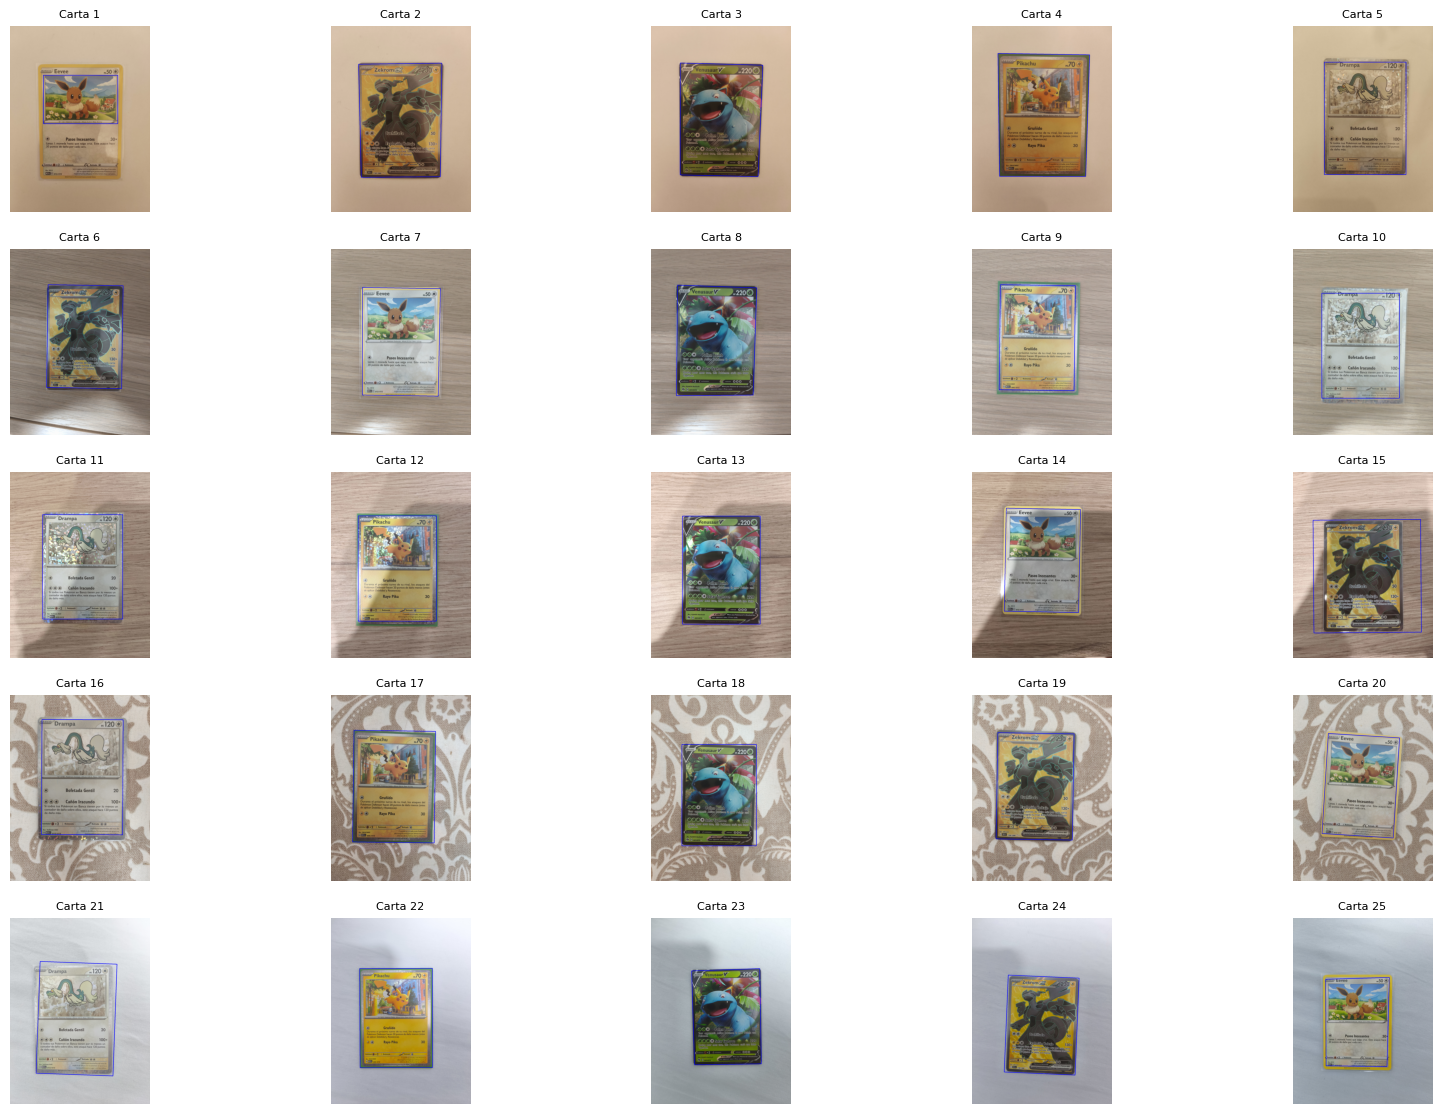

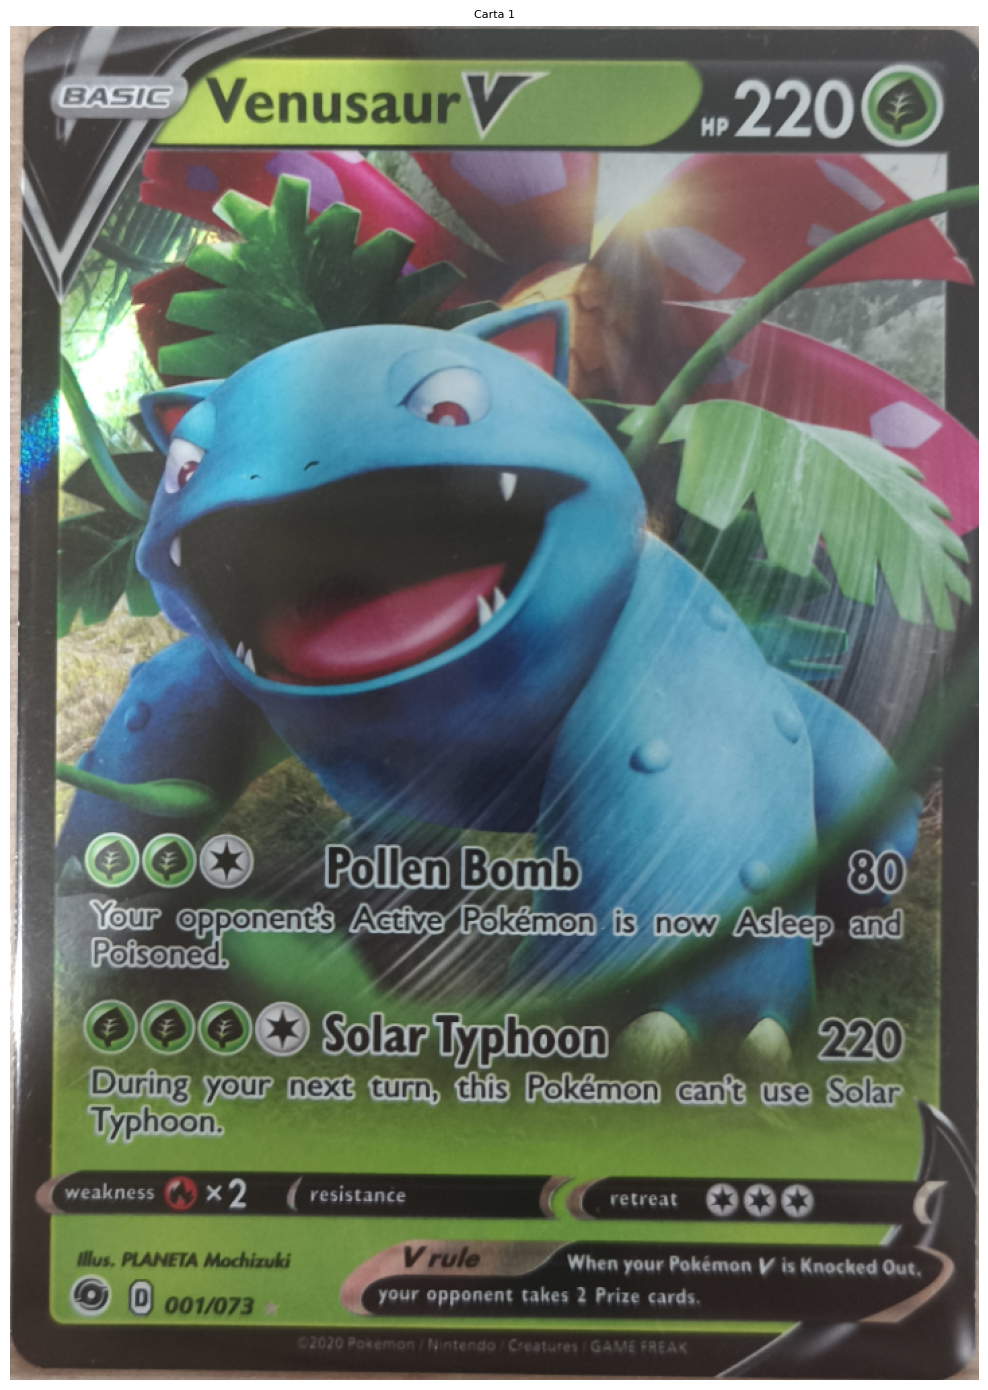

In [9]:
def cargarYDibujarContornos(index):
    ruta = images_path + "/Final/" + "Final_" + str(index) + ".jpg"
    numContorno, numAdaptativo, numHough = 0,0,0

    img_color, img_gray, edges = cargar_y_preprocesar(ruta)

    # 2) detección por contornos
    quad_cnt = encontrar_carta_como_quad(edges)
    if quad_cnt is not None:
        print("Contorno encontrado: ", index)
        numContorno += 1



    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_adaptativo_rect(img_color)
        if quad_cnt is not None:	print("Método adaptativo encontró carta: ", index)
        numAdaptativo += 1
        
    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_hough_rectas(img_color)
        if quad_cnt is not None:	print("Método hough encontró carta: ", index)
        numHough += 1
    
    img_cnt = img_color.copy()
    if quad_cnt is not None:
        cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
    else:
        cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    return img_cnt, quad_cnt, img_color, numContorno, numAdaptativo, numHough

# Crear una figura grande con todas las imágenes en matriz
num_imagenes = 25
filas = 5
columnas = 5
contorno, adaptativo, hough = 0, 0, 0

plt.figure(figsize=(20, 14))  # Tamaño grande para ver bien todas las cartas

for i in range(1, num_imagenes + 1):
    img_contornos, quad_cnt, img_color, numContorno, numAdaptativo, numHough = cargarYDibujarContornos(i)
    
    contorno += numContorno
    adaptativo += numAdaptativo
    hough += numHough

    # Solo rectificar si encontramos contorno
    '''
    if quad_cnt is not None:
        img_contornos = rectificar_carta(img_color, quad_cnt)
    '''
    plt.subplot(filas, columnas, i)
    plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
    plt.title(f"Carta {i}", fontsize=8)
    plt.axis('off')

print("Intentos - Contorno:", contorno, " Adaptativo:", adaptativo, " Hough:", hough)


plt.figure(figsize=(20, 14))  # Tamaño grande para ver bien todas las cartas
imagen, quad_cnt, img_color, numContorno, numAdaptativo, numHough = cargarYDibujarContornos(13)
if quad_cnt is not None:
    img_contornos = rectificar_carta(img_color, quad_cnt)
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title(f"Carta 1", fontsize=8)
plt.axis('off')

plt.tight_layout()  # Ajusta el espaciado entre imágenes
plt.show()